In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import time as time
import pyarrow as pa
import dask.dataframe as dd
from dask.distributed import Client
import dask
import gc
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
def wind_eval(orig_height, target_height, ds, surface_roughness):
    """Takes in an xarray dataset and evaluates the wind speed magnitude at a certain height using formula, 
    then creates a new variables and assigns it to the database and replaces the original wind speed magnitude.
    Note: Sets values of wind magnitude > 25m/s to zero."""
    #creating magnitude
    ds = ds.assign(wind_mag=lambda ds: np.sqrt(ds.u100**2 + ds.v100**2))
    
    #function to adjust for height of wind turbine
    def multiply(x,surface_roughness=surface_roughness,orig_height=orig_height,target_height=target_height):
        alpha = 0.5*(surface_roughness/10)**0.2
        factor = (target_height/orig_height)**alpha
        return x*factor
        
    ds['wind_mag'] = xr.apply_ufunc(multiply, ds['wind_mag'],input_core_dims=[["longitude","latitude"]],
               output_core_dims=[["longitude", "latitude"]], dask = 'allowed', vectorize = True)
    #dropping values above 25ms-1 (cut-out speed)
    ds['wind_mag'] = ds['wind_mag'].where((ds['wind_mag']<=25) & (ds['wind_mag']>0),0, drop=False)
    ds.wind_mag.attrs["units"] = "m s**-1"
    return ds

In [3]:
#importing dataset
paths = ["/share/data1/xzcaplbl/100m_1982_to_2022_8.3MW.nc"]
paths2 = ["/share/data1/xzcaplbl/100m_1982_to_2022_8.MW.nc"]
ds = xr.open_mfdataset(paths, parallel=True,chunks={'latitude': -1, 'longitude': -1, 'time': -1} ,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')
ds2 = xr.open_mfdataset(paths2, parallel=True,chunks={'latitude': -1, 'longitude': -1, 'time': -1} ,concat_dim='time', data_vars='minimal',combine='nested',coords='minimal',compat='override')

/share/data1/xzcaplbl/anaconda3/lib/python3.11/site-packages/gribapi/__init__.py:23: UserWarning: ecCodes 2.31.0 or higher is recommended. You are running version 2.29.0
  warnings.warn(


In [4]:
longitude = 5
latitude = 60


power_ds = ds.sel(latitude=[latitude], longitude=[longitude])['power']

#creating rolling averages
power_ds['4hr_avg'] = power_ds.rolling(time=4).mean()
power_ds['8hr_avg'] = power_ds.rolling(time=8).mean()
power_ds['12hr_avg'] = power_ds.rolling(time=12).mean()
power_ds['24hr_avg'] = power_ds.rolling(time=24).mean()
power_ds['48hr_avg'] = power_ds.rolling(time=48).mean()
power_ds['36hr_avg'] = power_ds.rolling(time=36).mean()
power_ds['1w_avg'] = power_ds.rolling(time=168).mean()
power_ds['2w_avg'] = power_ds.rolling(time=336).mean()

In [5]:
longitude = 5
latitude = 60


power_ds2 = ds2.sel(latitude=[latitude], longitude=[longitude])['power']

#creating rolling averages
power_ds2['4hr_avg'] = power_ds2.rolling(time=4).mean()
power_ds2['8hr_avg'] = power_ds2.rolling(time=8).mean()
power_ds2['12hr_avg'] = power_ds2.rolling(time=12).mean()
power_ds2['24hr_avg'] = power_ds2.rolling(time=24).mean()
power_ds2['48hr_avg'] = power_ds2.rolling(time=48).mean()
power_ds2['36hr_avg'] = power_ds2.rolling(time=36).mean()
power_ds2['1w_avg'] = power_ds2.rolling(time=168).mean()
power_ds2['2w_avg'] = power_ds2.rolling(time=336).mean()

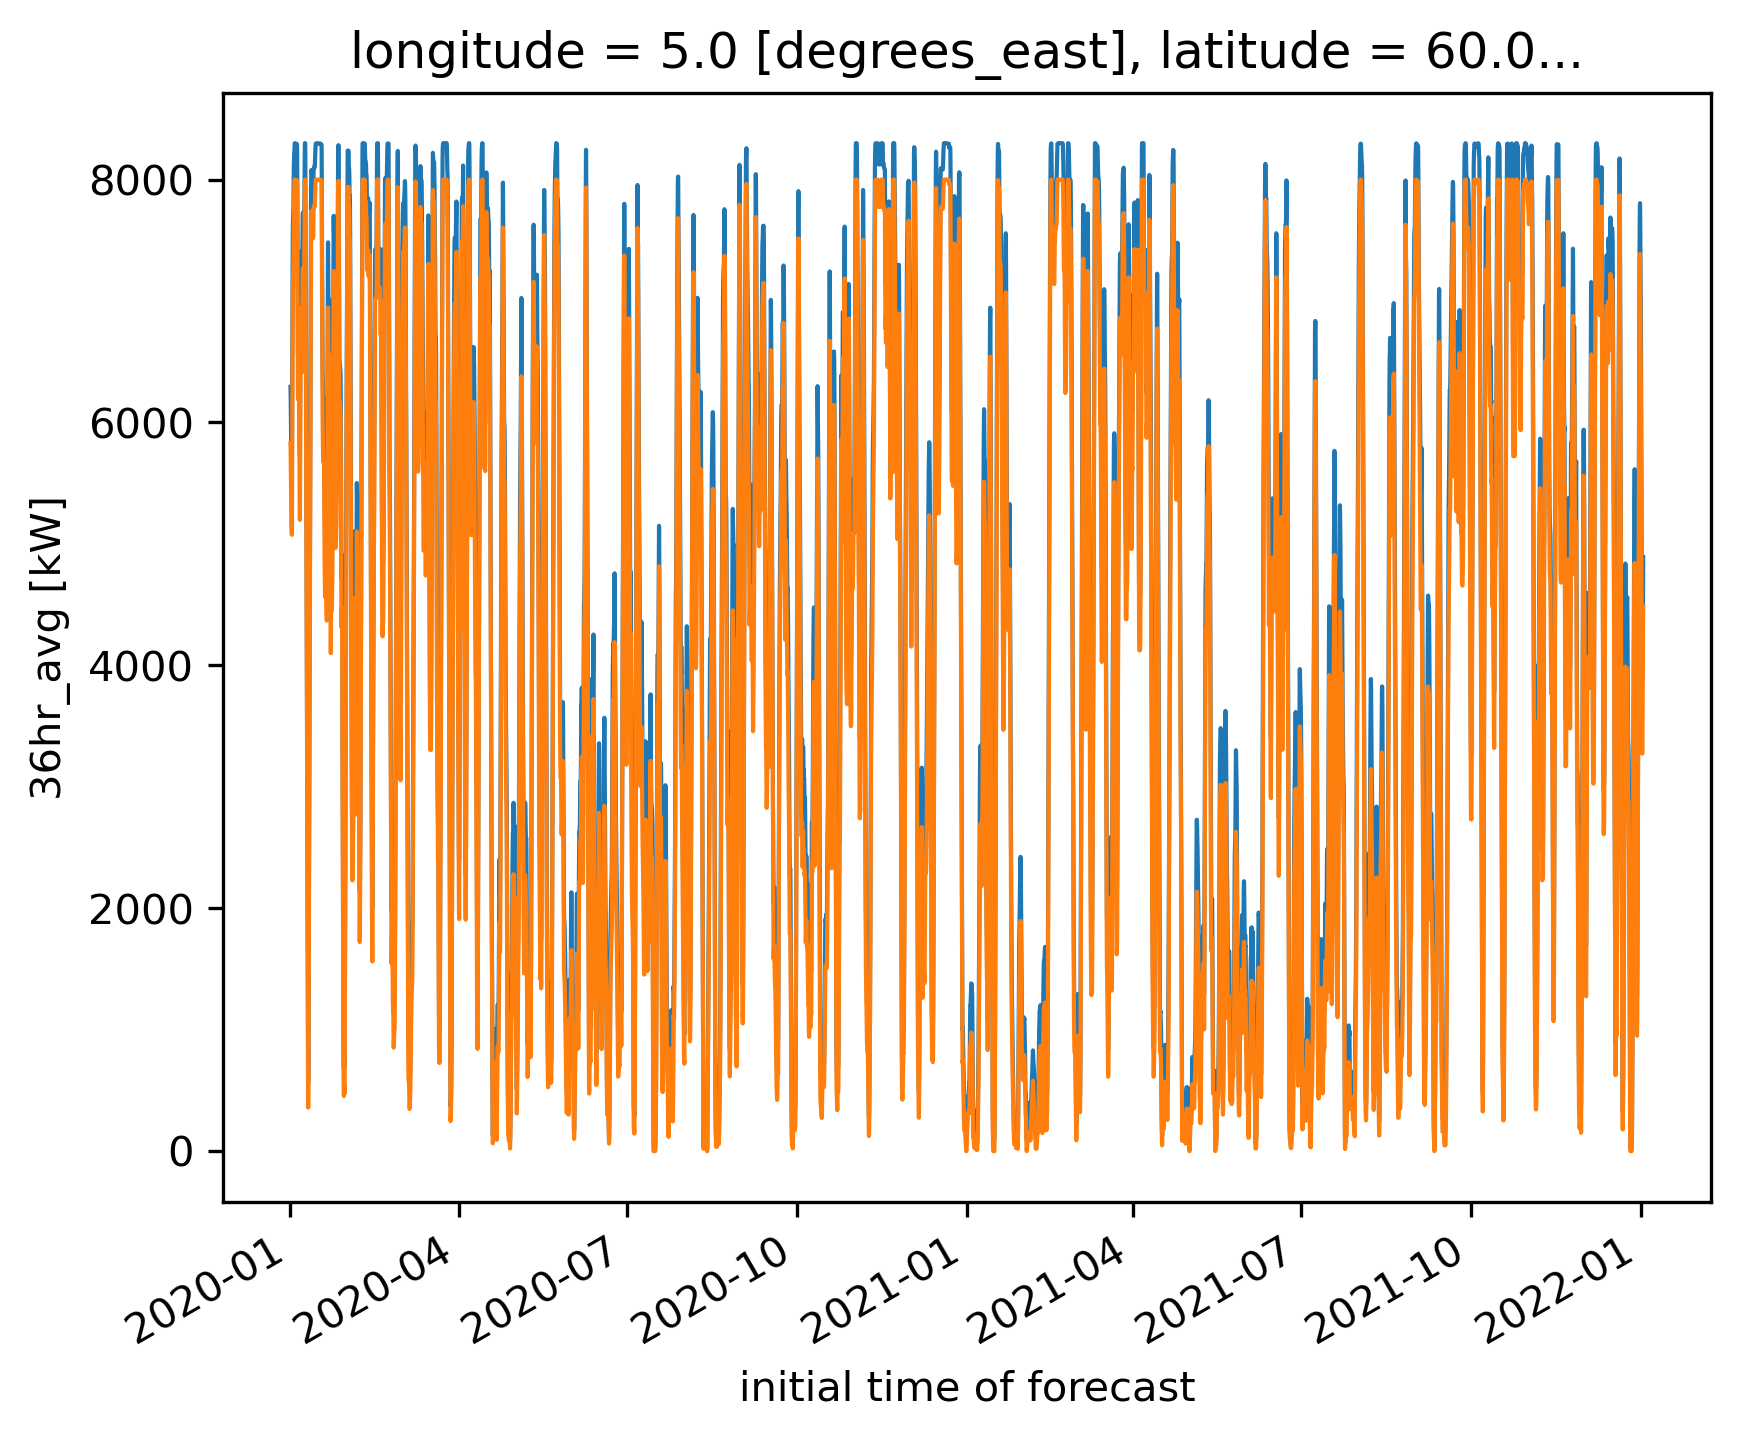

In [6]:
plt.figure(dpi=300)
power_ds['36hr_avg'].sel(time=slice('2020-01-01', '2022-01-01')).plot(linewidth=1,label = "2023 8.3MW")
power_ds2['36hr_avg'].sel(time=slice('2020-01-01', '2022-01-01')).plot(linewidth=1, label = "2015 8.0MW")


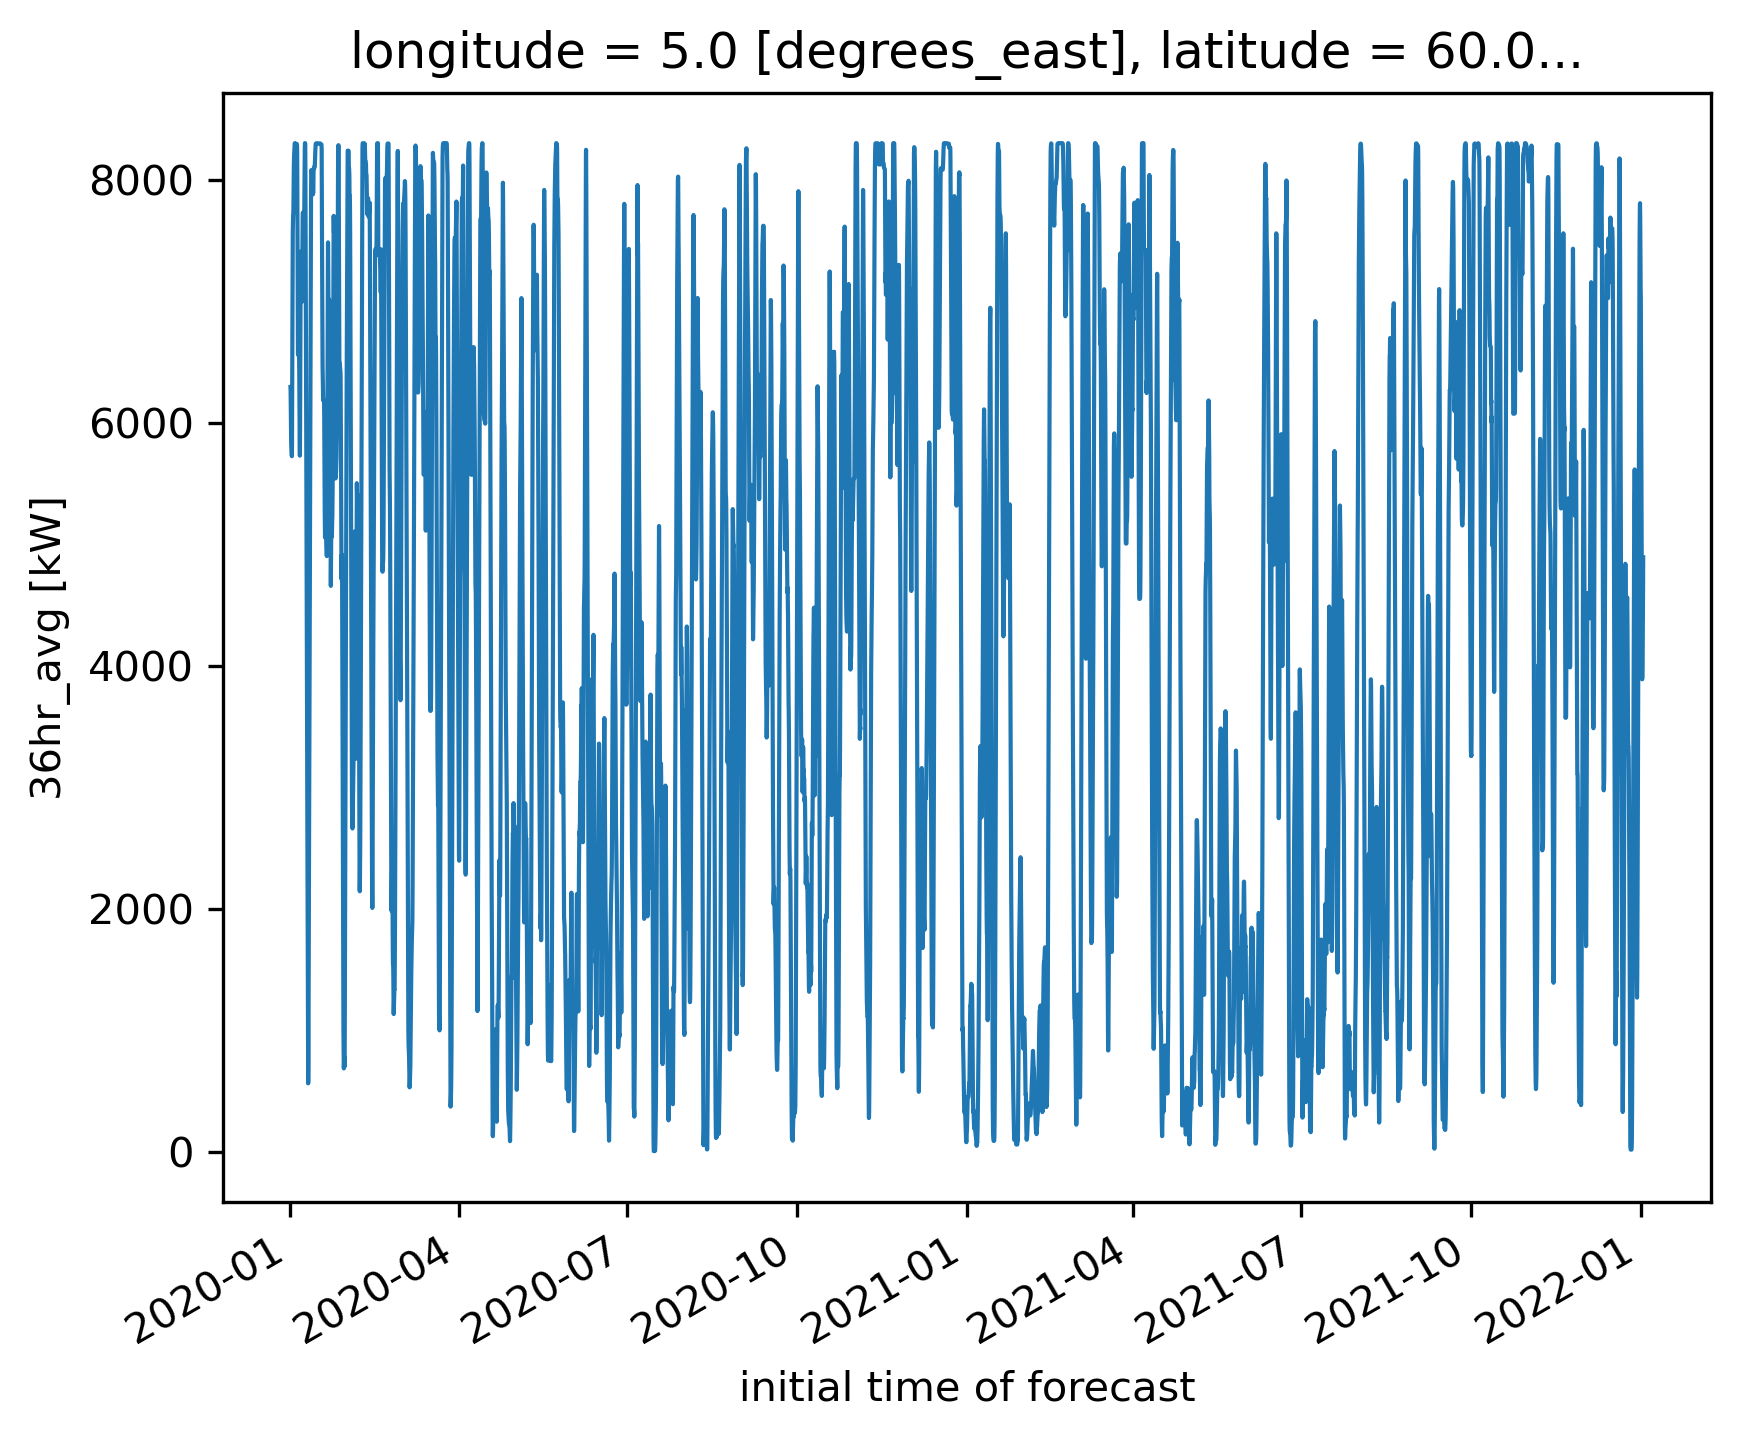

In [7]:
plt.figure(dpi=300)
power_ds['36hr_avg'].sel(time=slice('2020-01-01', '2022-01-01')).plot(linewidth=1,label = "2023 8.3MW")

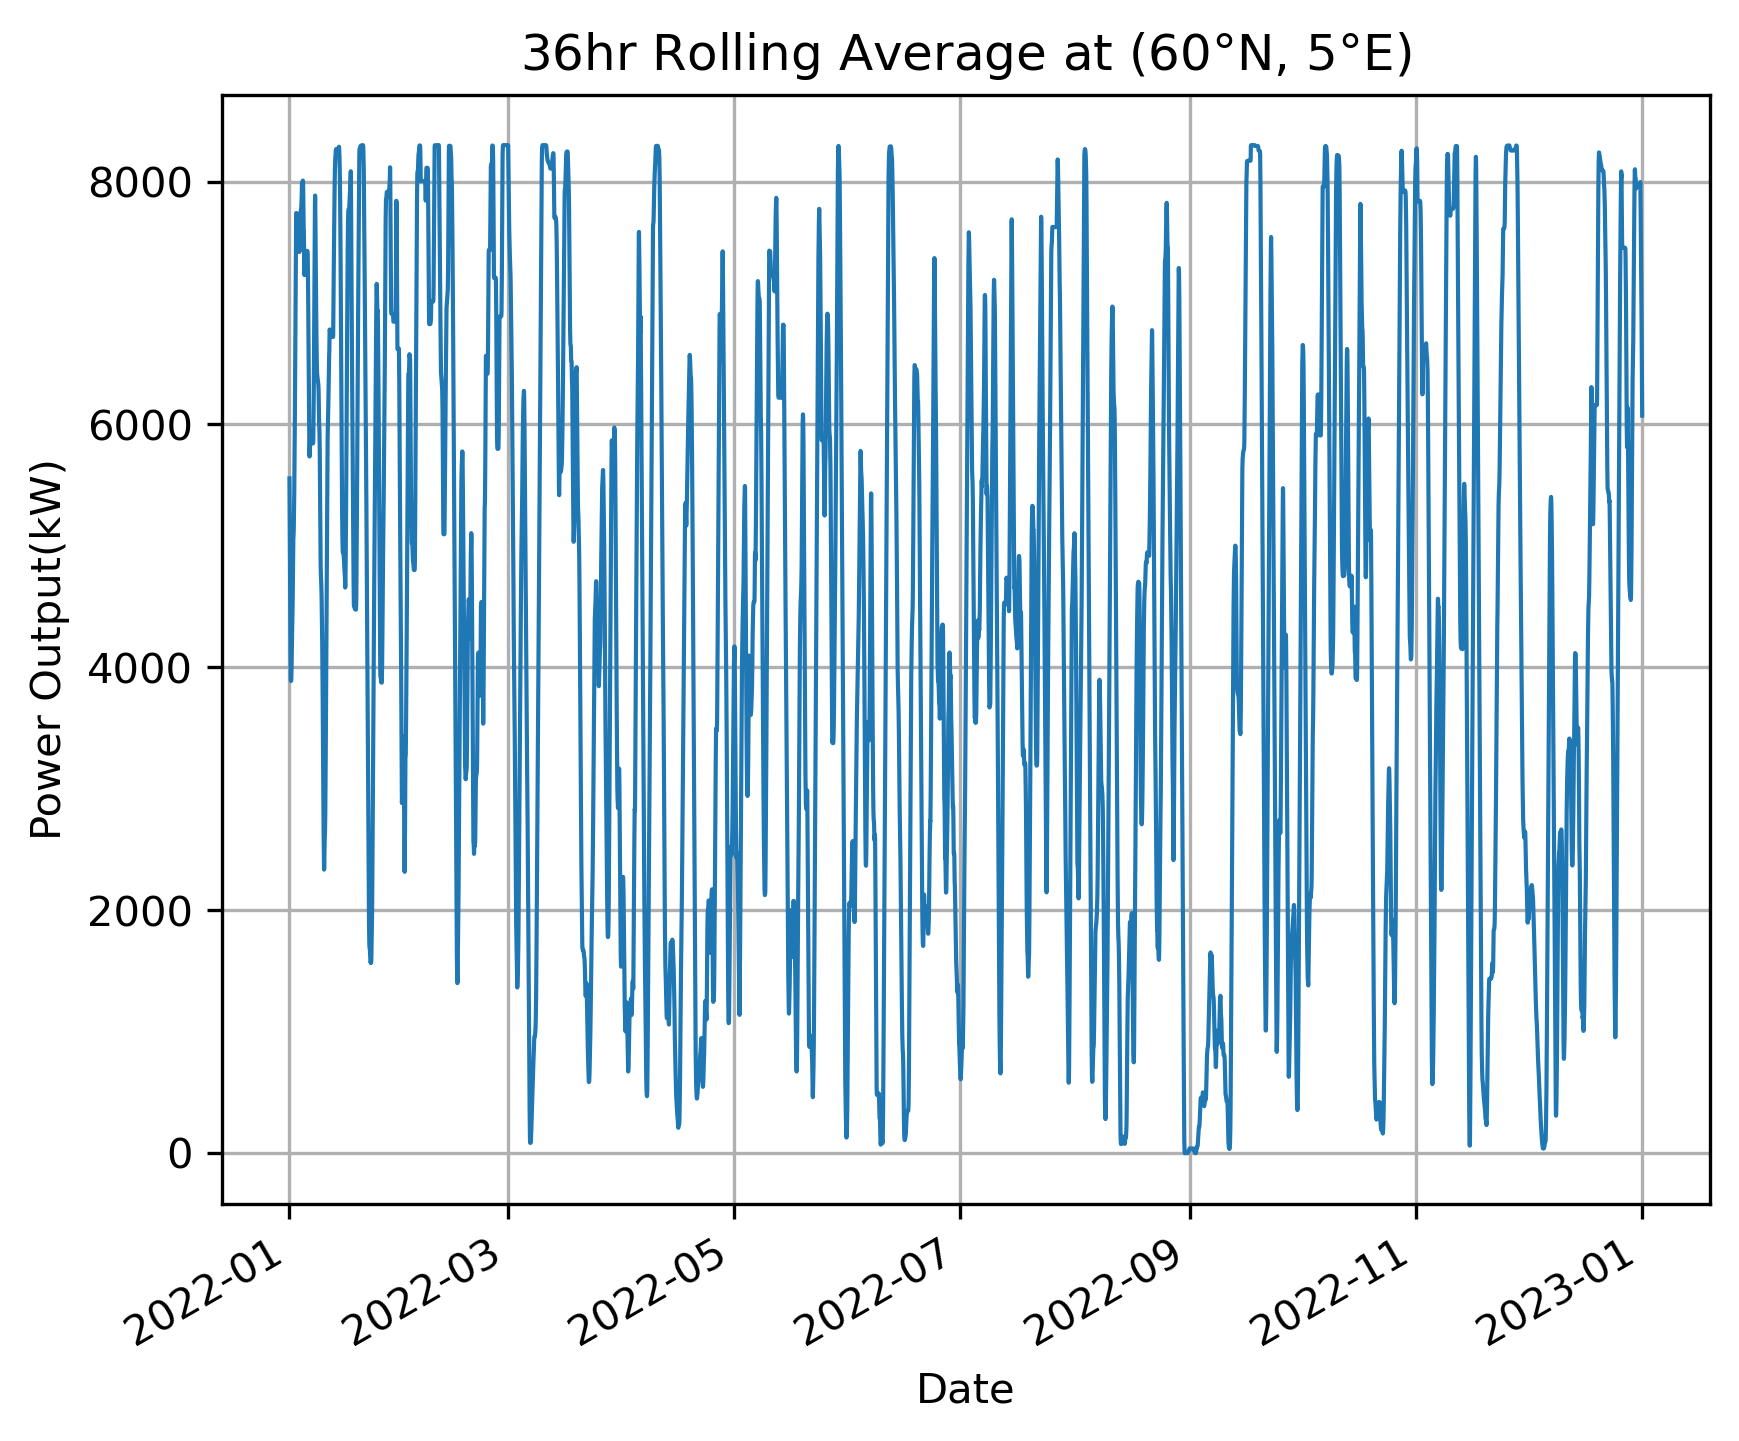

In [8]:
plt.figure(dpi=300)
power_ds['36hr_avg'].sel(time=slice('2022-01-01', '2023-01-01')).plot(linewidth=1)
#power_ds2['36hr_avg'].sel(time=slice('2022-11-01', '2023-01-01')).plot(linewidth=1)
plt.title(f'36hr Rolling Average at (${latitude}\degree$N, ${longitude}\degree$E)')
plt.xlabel('Date')
plt.ylabel('Power Output(kW)')
plt.grid()



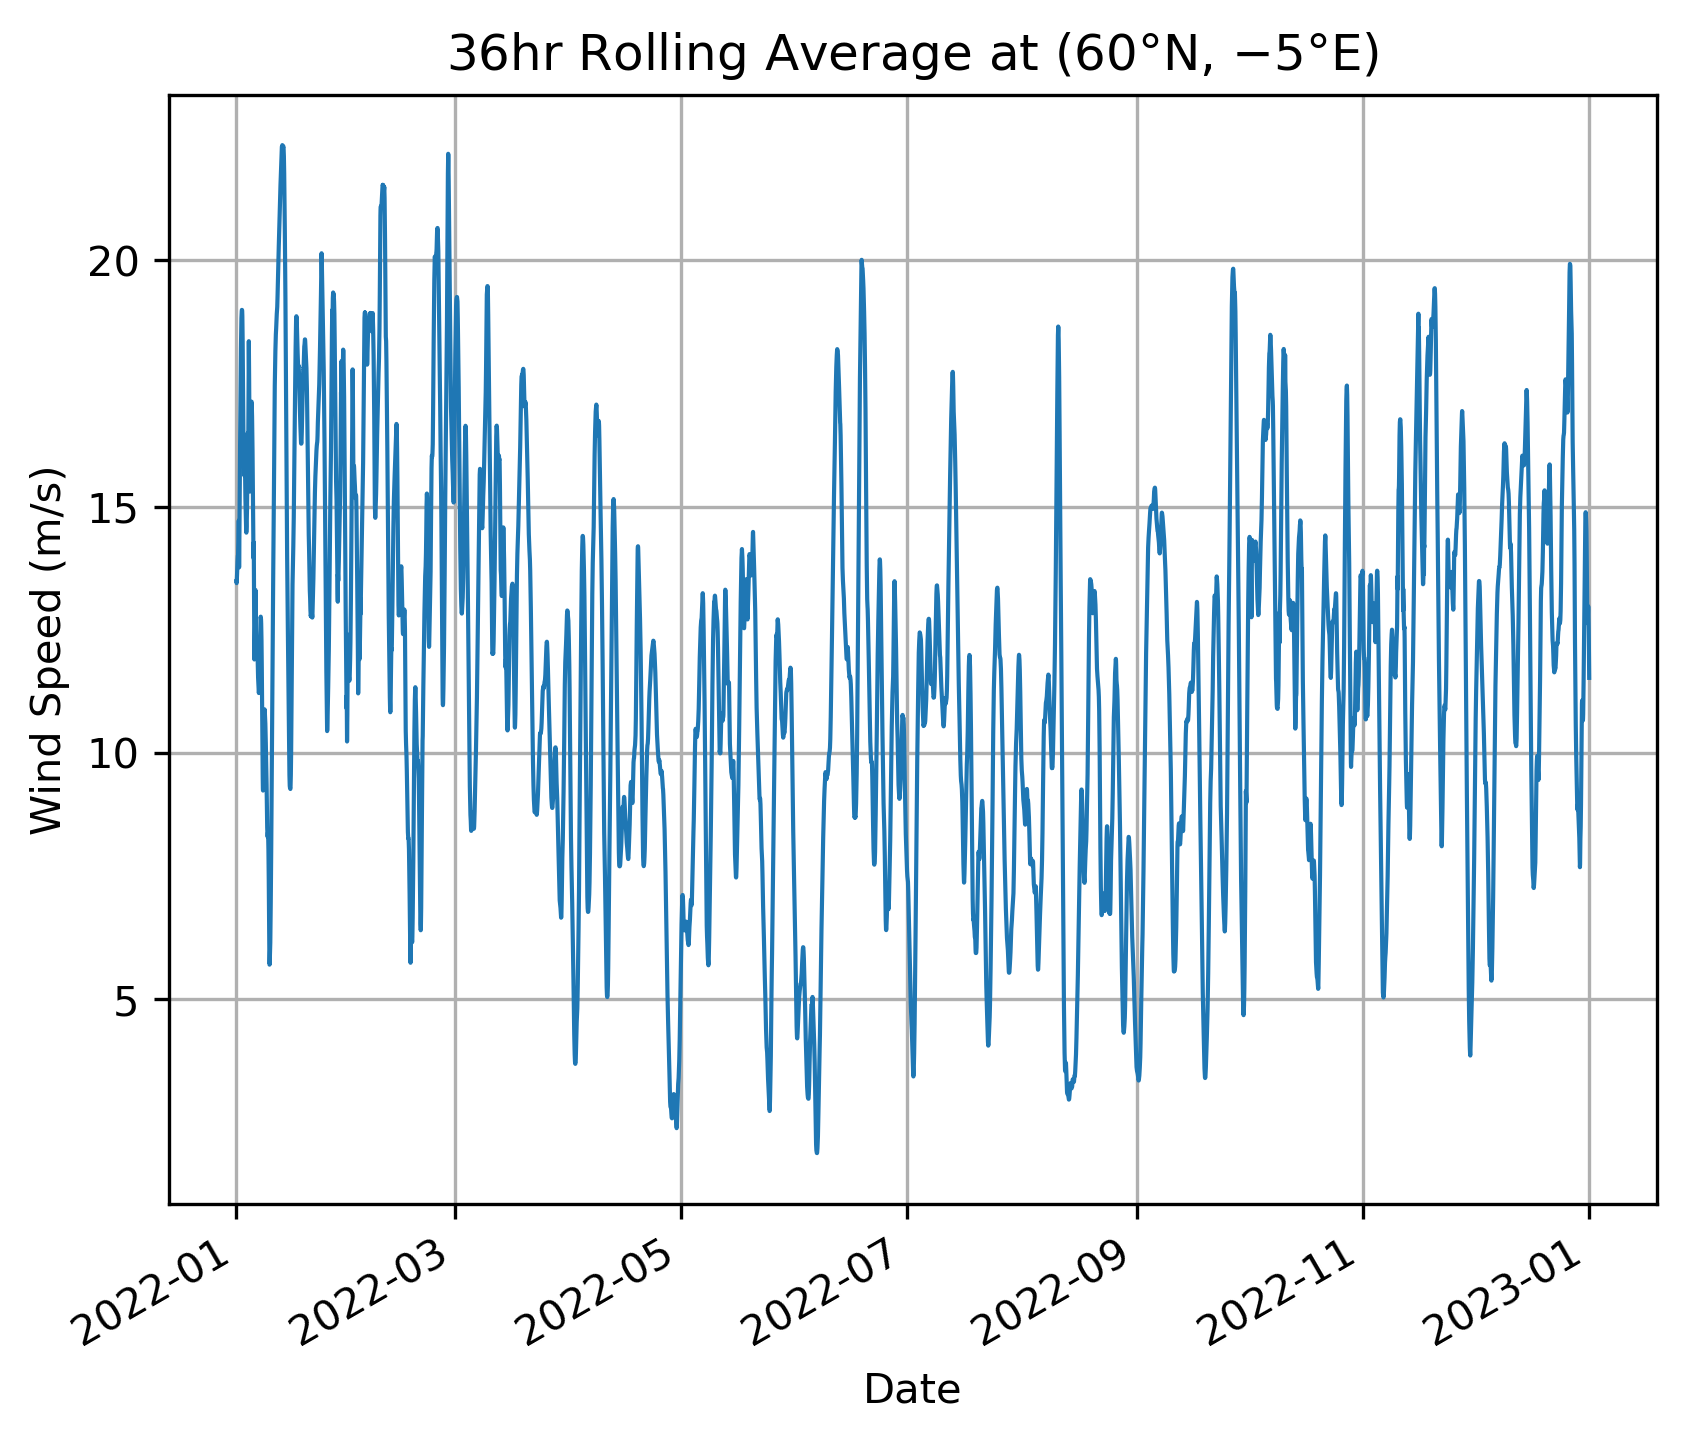

In [9]:
longitude = -5
latitude = 60


mag_ds = ds.sel(latitude=[latitude], longitude=[longitude])['wind_mag']


mag_ds['36hr_avg'] = mag_ds.rolling(time=36).mean()


plt.figure(dpi=300)
mag_ds['36hr_avg'].sel(time=slice('2022-01-01', '2023-01-01')).plot(linewidth=1)
#power_ds2['36hr_avg'].sel(time=slice('2022-11-01', '2023-01-01')).plot(linewidth=1)
plt.title(f'36hr Rolling Average at (${latitude}\degree$N, ${longitude}\degree$E)')
plt.xlabel('Date')
plt.ylabel('Wind Speed (m/s)')
plt.grid()


In [29]:
avg_nums = np.logspace(0,2.5265,40, dtype='int')
avg_nums = np.arange(1,337) #1hr to 2 weeks
num_lulls = np.empty(avg_nums.shape[0],dtype='float64')
start_date = '1982-01-01' #1998-01-01
end_date = '2022-12-31' #2021-12-31
cut_off = 0.01
max_power = 8300*cut_off
num_yrs = 40

for i in range(avg_nums.shape[0]):
    #start = time.time()
    working_ds = (ds.sel(time=slice(start_date, end_date), latitude=[latitude], longitude=[longitude])['power']
                  .rolling(time=avg_nums[i])
                  .mean())
    
    num = (working_ds.where(working_ds < max_power))
    num_next = num.where((num.shift(time=+1).isnull() != False) & (num.shift(time=-1).isnull() != False))
    num_lulls[i] = num_next.count(dim='time').values 



In [30]:
longitude1 = 5
latitude1 = 55


avg_nums2 = np.logspace(0,2.5265,40, dtype='int')
avg_nums2 = np.arange(1,337) #1hr to 2 weeks
num_lulls2 = np.empty(avg_nums.shape[0],dtype='float64')
start_date2 = '1982-01-01' #1998-01-01
end_date2 = '2022-12-31' #2021-12-31
cut_off2 = 0.01
max_power2 = 8300*cut_off
num_yrs2 = 40




for i in range(avg_nums.shape[0]):
    #start = time.time()
    working_ds = (ds.sel(time=slice(start_date2, end_date2), latitude=[latitude1], longitude=[longitude1])['power']
                  .rolling(time=avg_nums2[i])
                  .mean())
    
    num2 = (working_ds.where(working_ds < max_power2))
    num_next2 = num2.where((num2.shift(time=+1).isnull() != False) & (num2.shift(time=-1).isnull() != False))
    num_lulls2[i] = num_next2.count(dim='time').values 

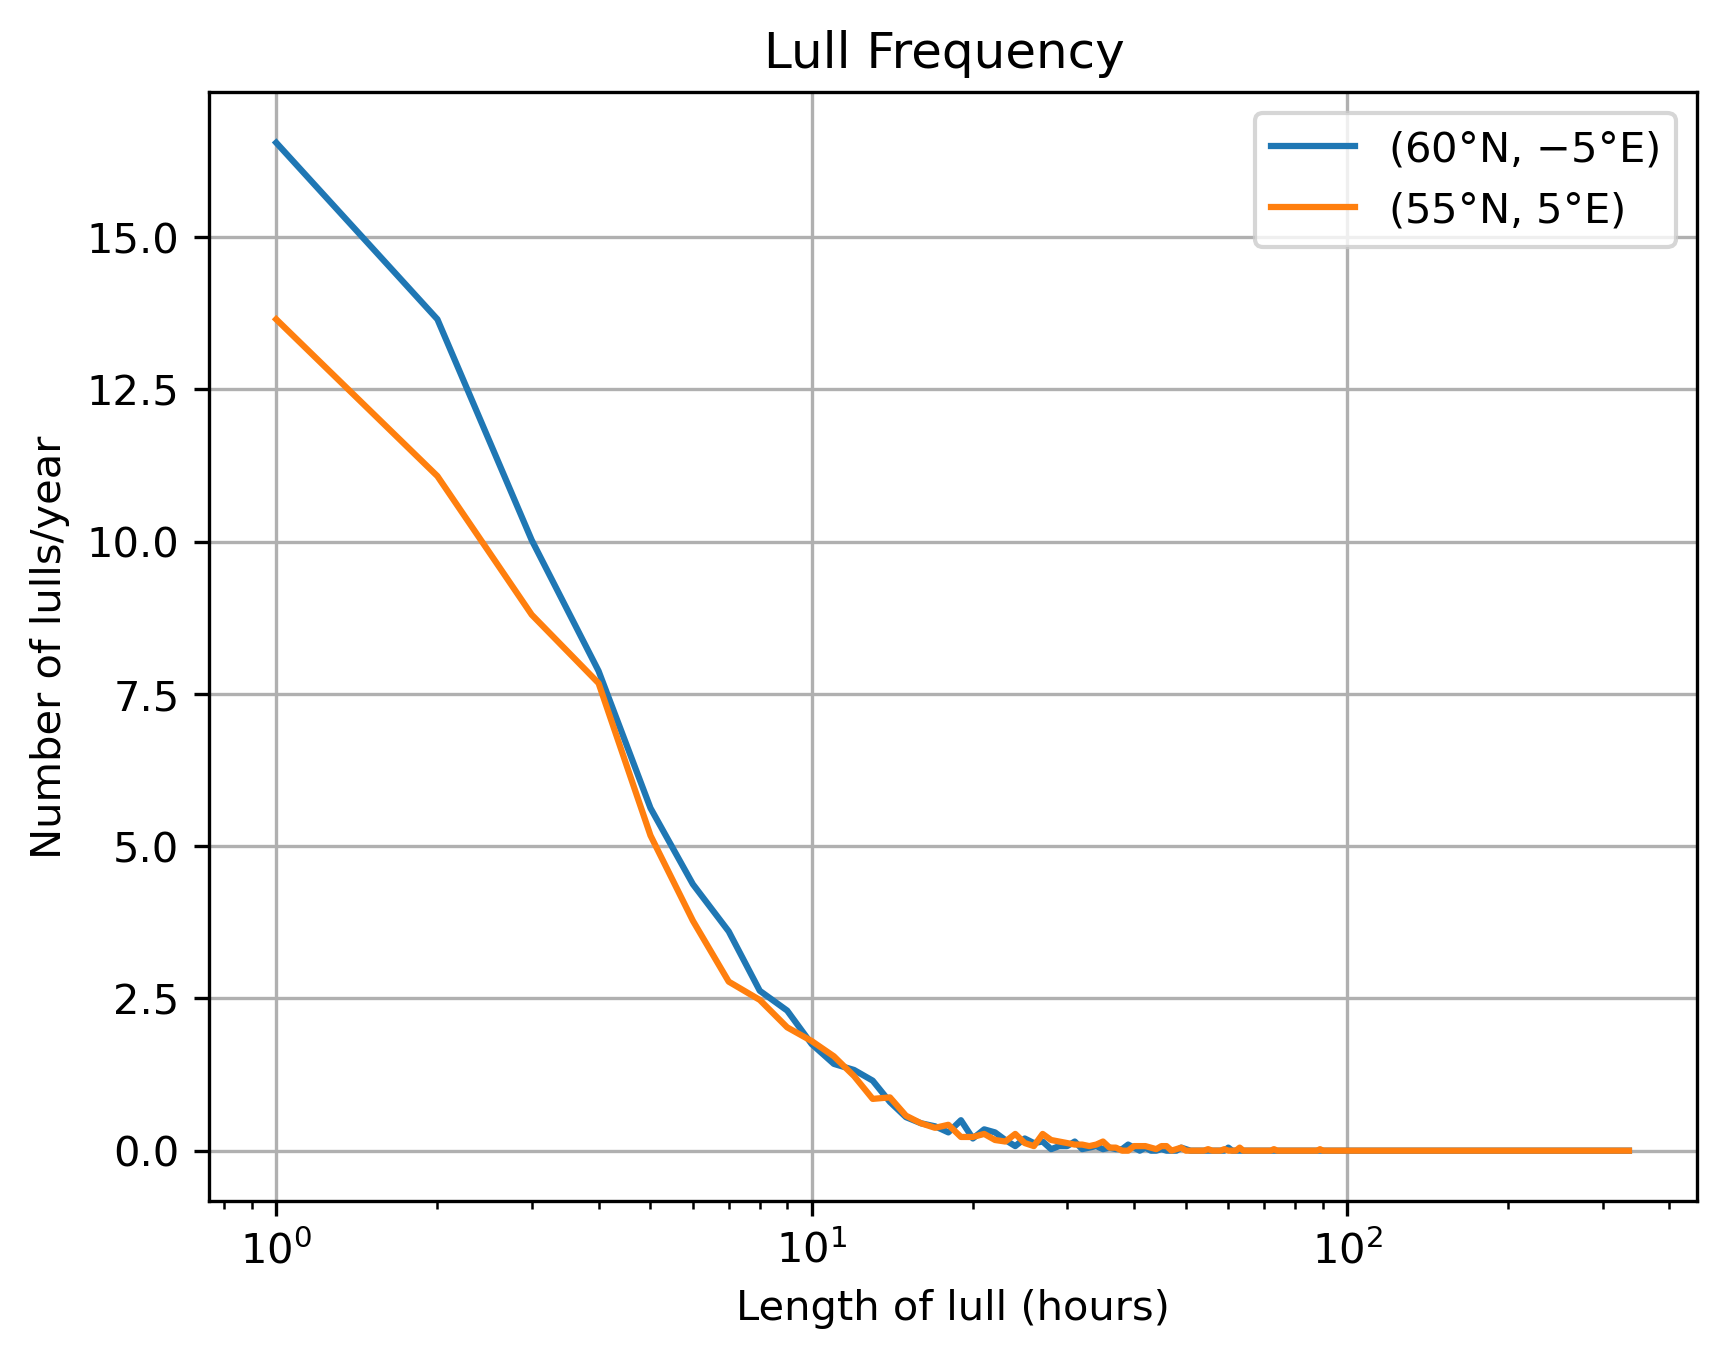

In [37]:
plt.figure(dpi=300)
plt.semilogx(avg_nums,num_lulls/num_yrs, label = (f"(${latitude}\degree$N, ${longitude}\degree$E)"))
plt.semilogx(avg_nums2,num_lulls2/num_yrs2, label = (f"(${latitude1}\degree$N, ${longitude1}\degree$E)"))
plt.xlabel('Length of lull (hours)')
plt.ylabel('Number of lulls/year')
plt.title(f'Lull Frequency ')
plt.legend(loc="best")
plt.grid()

In [48]:
print("Number of lulls per year that are 1 hour long:", num_lulls[0])





Number of lulls per year that are 1 hour long: 57.0
